In [44]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [45]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [46]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7

In [47]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


In [48]:
# split train into a train and test set 
train, test = train_test_split(train, test_size=0.2, random_state=42)

In [49]:
#for each column, check how many non-empty rows are in the dataframe
# train.info()

#drop the columns less than 75% full
train = train.dropna(thresh=0.75*len(train), axis=1)
test = test[train.columns]

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6456 entries, 7709 to 7270
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      6456 non-null   object 
 1   site_id                                 6456 non-null   object 
 2   site_latitude                           6456 non-null   float64
 3   site_longitude                          6456 non-null   float64
 4   city                                    6456 non-null   object 
 5   country                                 6456 non-null   object 
 6   date                                    6456 non-null   object 
 7   hour                                    6456 non-null   int64  
 8   month                                   6456 non-null   float64
 9   uvaerosolindex_absorbing_aerosol_index  6452 non-null   float64
 10  uvaerosolindex_sensor_altitude          6452 non-null   float6

In [50]:


# combine city and country into one column
train['Location'] = train['country'] + ', ' + train['city']
test['Location'] = test['country'] + ', ' + test['city']
train.drop(['country', 'city'], axis=1, inplace=True)
test.drop(['country', 'city'], axis=1, inplace=True)

train.describe()

,site_latitude,site_longitude,hour,month,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5
count,6456.000000,6456.000000,6456.000000,6456.000000,6452.000000,6452.000000,6452.000000,6452.000000,6452.000000,6452.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6456.000000
mean,0.611788,30.343979,10.874690,6.159077,-0.448394,829600.321694,-12.767938,41.344141,-88.883719,28.410662,0.117710,2.648199,0.316087,228.271748,0.515899,-13.419094,41.248820,-88.669701,28.552058,24.439187
std,2.135051,9.288564,0.808708,3.422476,0.749539,356.050855,86.514866,18.883171,41.279566,6.881873,0.004369,0.412445,0.049176,3.813944,0.365868,86.522586,18.772737,41.261238,6.784093,24.429007
min,-3.459970,3.201510,10.000000,1.000000,-2.703881,828534.875000,-107.710861,0.177093,-165.131509,9.250222,0.104063,2.020408,0.222735,208.920700,0.000000,-107.710861,0.177093,-165.131509,10.316818,1.200000
25%,0.288630,32.568643,10.000000,3.000000,-0.979388,829353.250000,-98.923601,26.928265,-127.644871,23.894016,0.115828,2.282283,0.273665,225.910682,0.176971,-98.936506,26.927854,-127.638301,24.021888,13.146200
50%,0.332610,32.600480,11.000000,6.000000,-0.464938,829633.531249,70.044989,45.789160,-83.421275,28.608427,0.118689,2.560616,0.307104,228.387230,0.461243,-95.878006,45.652317,-83.377270,28.698396,18.314000
75%,0.374653,32.647109,11.000000,9.000000,-0.000345,829844.187500,73.478592,58.090499,-50.453244,33.412814,0.120675,2.949266,0.352034,230.808394,0.932658,73.492739,57.406958,-50.198281,33.454805,28.721500
max,6.595400,36.914272,14.000000,12.000000,2.245471,830988.875000,77.319656,66.453850,-22.275669,45.496357,0.128846,3.649251,0.440975,242.670975,1.000000,77.319656,66.239106,-22.274576,45.496357,456.193333


In [ ]:
# draw a correlation matrix for the columns that include: "uvaerosolindex", "ozone", 

In [18]:
# summarise categorical variables
train.describe(include=['O'])

,id,site_id,date,Location
count,6456,6456,6456,6456
unique,6456,69,323,4
top,id_n9zf7av5aw,616fe4ce9657420029658b3e,2024-01-25,"Uganda, Kampala"
freq,1,229,48,4472


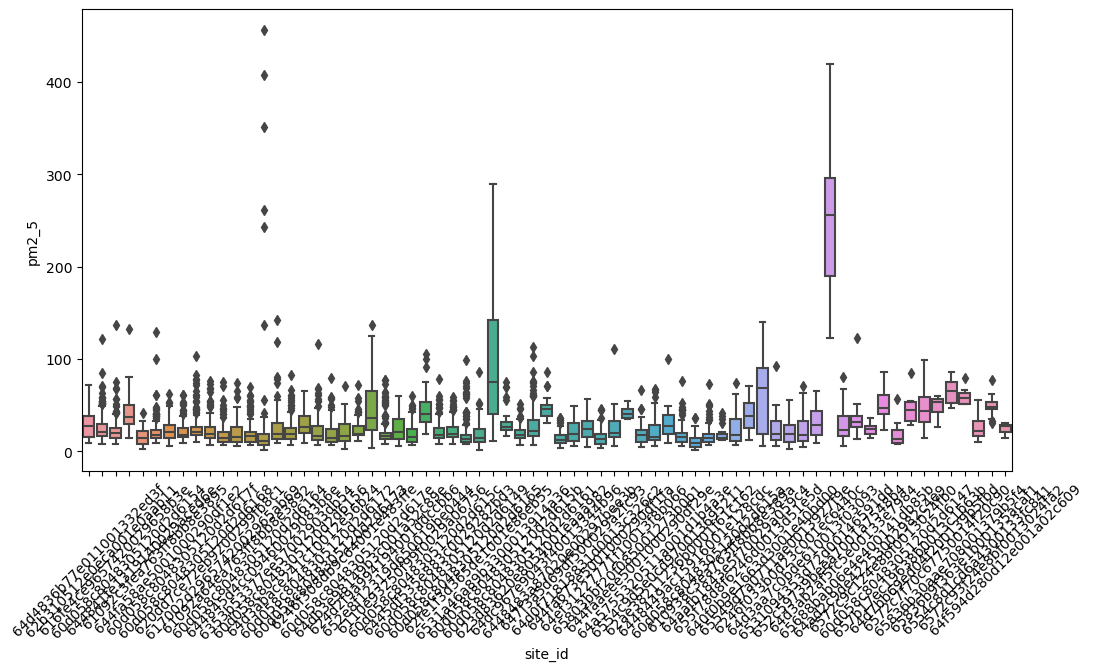

In [19]:
# show pm2_5 distributions based on the site_id
plt.figure(figsize=(12, 6))
sns.boxplot(x='site_id', y='pm2_5', data=train)
plt.xticks(rotation=45)
plt.show()

In [51]:
#drop all rows with missing values
train = train.dropna()
test = test.dropna()

#print the number of data values
train.shape

(6374, 24)

In [21]:
# summarise categorical variables
train.describe(include=['O'])

# summarise the distributions of pm2_5 based on the Location variable
train.groupby('Location')['pm2_5'].describe()

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
"Burundi, Bujumbura",100.0,30.368101,21.334810,5.555000,16.658313,26.995066,37.736229,122.552188
"Kenya, Nairobi",1218.0,18.820753,24.491965,1.200000,8.972885,15.011150,23.515491,456.193333
"Nigeria, Lagos",663.0,45.796602,52.155899,3.264615,18.364855,34.021875,50.915975,419.481190
"Uganda, Kampala",4393.0,22.704719,14.412929,5.505600,13.797600,18.078300,27.139200,142.464800


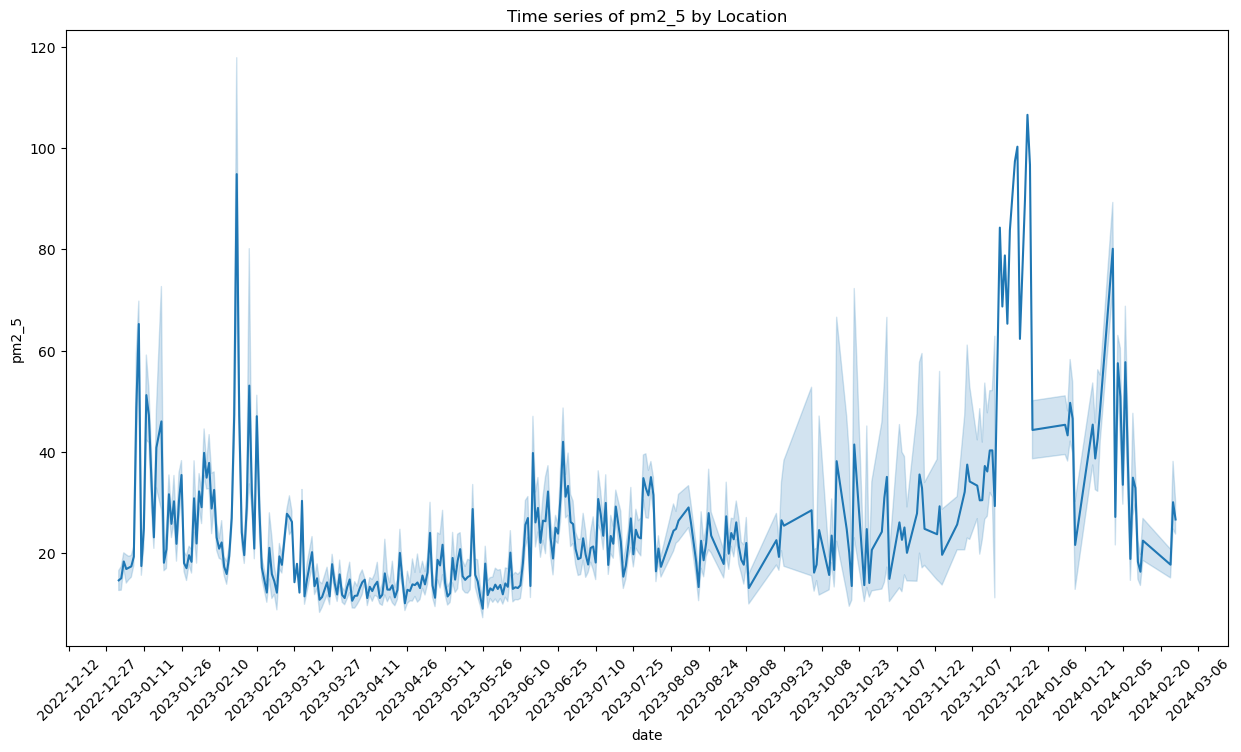

In [52]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train)

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

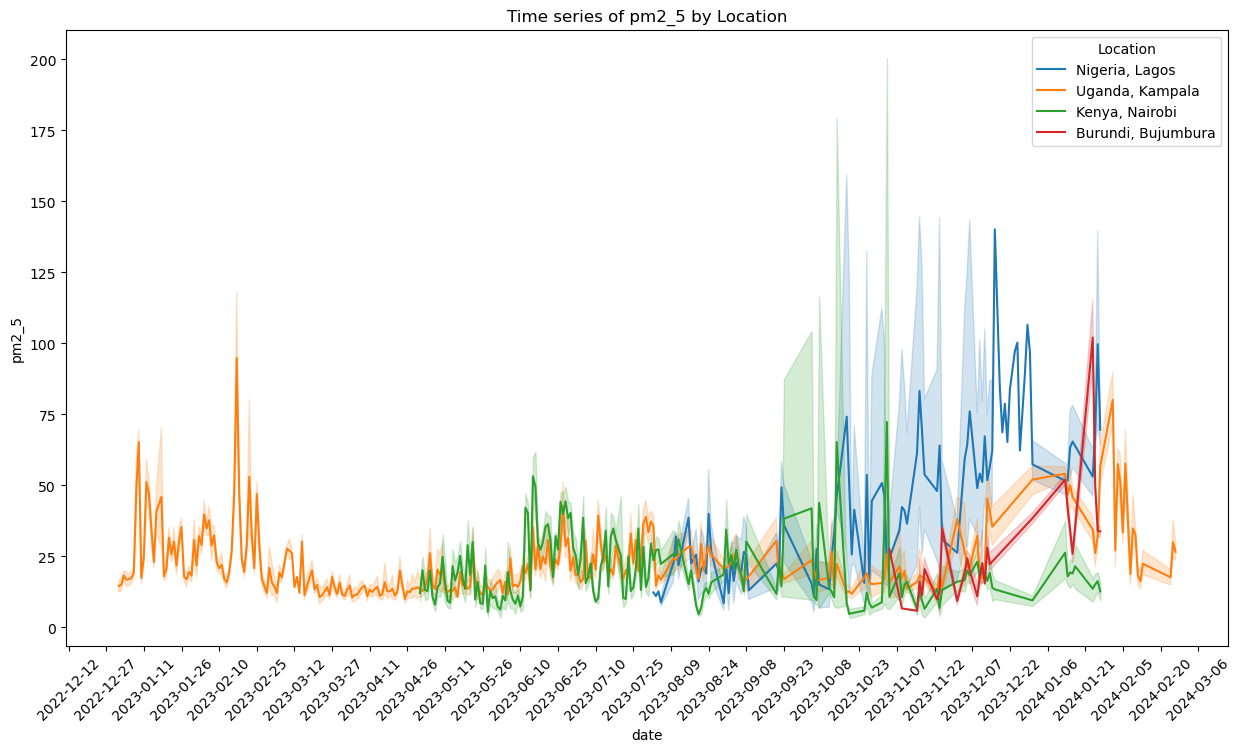

In [23]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train, hue='Location')

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

In [24]:
# list the columns of train
print(train.columns)

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'date', 'hour',
       'month', 'uvaerosolindex_absorbing_aerosol_index',
       'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
       'uvaerosolindex_sensor_zenith_angle',
       'uvaerosolindex_solar_azimuth_angle',
       'uvaerosolindex_solar_zenith_angle', 'ozone_o3_column_number_density',
       'ozone_o3_column_number_density_amf',
       'ozone_o3_slant_column_number_density',
       'ozone_o3_effective_temperature', 'ozone_cloud_fraction',
       'ozone_sensor_azimuth_angle', 'ozone_sensor_zenith_angle',
       'ozone_solar_azimuth_angle', 'ozone_solar_zenith_angle', 'pm2_5',
       'Location'],
      dtype='object')


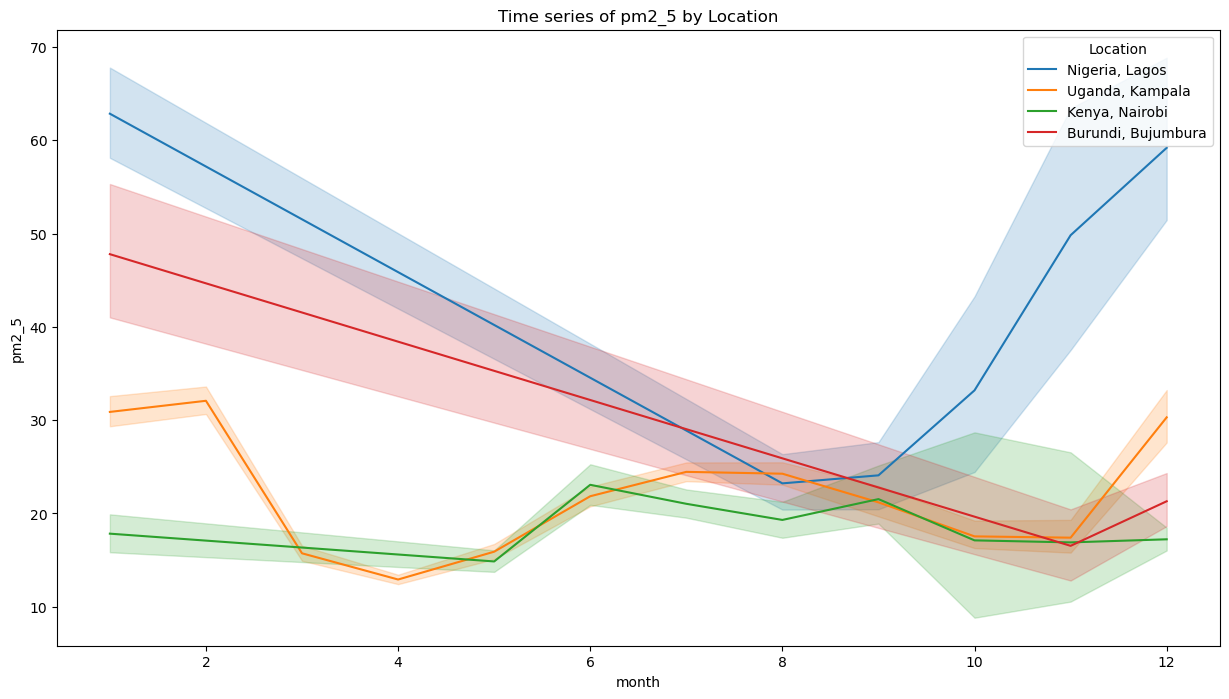

In [25]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='month', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

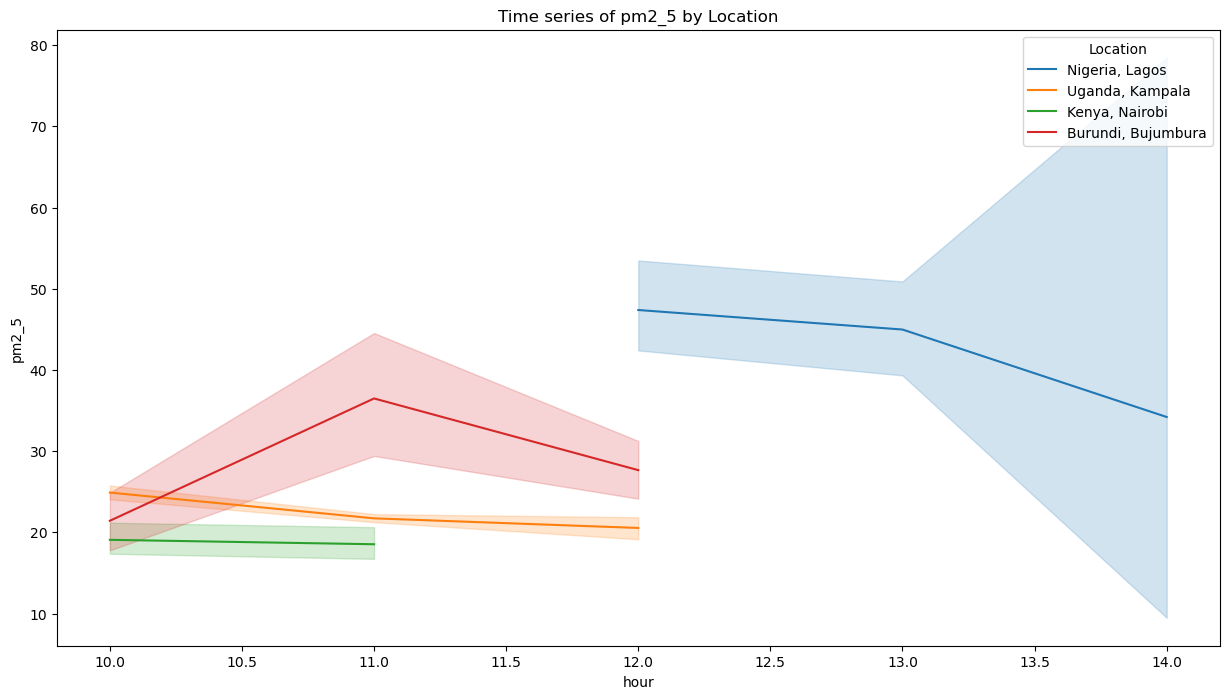

In [26]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='hour', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

In [53]:
# list non-categorical columns
non_categorical = train.select_dtypes(include=[np.number]).columns
# remove hour, month, latitude and longitude from this list
non_categorical = non_categorical.drop(['hour', 'month', 'site_latitude', 'site_longitude', 'pm2_5'])
non_categorical

Index(['uvaerosolindex_absorbing_aerosol_index',
       'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
       'uvaerosolindex_sensor_zenith_angle',
       'uvaerosolindex_solar_azimuth_angle',
       'uvaerosolindex_solar_zenith_angle', 'ozone_o3_column_number_density',
       'ozone_o3_column_number_density_amf',
       'ozone_o3_slant_column_number_density',
       'ozone_o3_effective_temperature', 'ozone_cloud_fraction',
       'ozone_sensor_azimuth_angle', 'ozone_sensor_zenith_angle',
       'ozone_solar_azimuth_angle', 'ozone_solar_zenith_angle'],
      dtype='object')

# Now we are training the regression model

In [54]:
# One-hot encode the 'site_id' column
train = pd.get_dummies(train, columns=['site_id'])
test = pd.get_dummies(test, columns=['site_id'])

In [55]:
# one hot encode the Location column
train = pd.get_dummies(train, columns=['Location'])
test = pd.get_dummies(test, columns=['Location'])

In [30]:
train.head()

,id,site_latitude,site_longitude,date,hour,month,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5,site_id_60d058c8048305120d2d6147,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_64f594d280d12e001a02c609,site_id_652c59739beea7001a7548b4,site_id_652e8f12319d650019be0444,site_id_6531094353d72d00146591dd,site_id_6531a46a89b3300013914a36,site_id_65549d7a0711ae0013927f9e,site_id_6554c8d1cd6a4300133fc841,site_id_6554c9d5e0cd970013695211,site_id_655f78d8f6246d0013d51e5d,site_id_65688bab06e4e400141db85b,site_id_6572c7f70c67750014f20c90,site_id_6572c93f24e8bf0013024fa2,site_id_6572c9c124e8bf0013024fb0,site_id_657b17ec19638b0013c1b63b,site_id_65803bbf20f085001273b0b1,site_id_65836b30aae708001379b5f4,site_id_65836b9f363e1b00135acaf1,"Location_Burundi, Bujumbura","Location_Kenya, Nairobi","Location_Nigeria, Lagos","Location_Uganda, Kampala"
7709,id_n9zf7av5aw,6.517670,3.385420,2023-09-22,13,9.0,-0.151367,829172.937500,-97.841881,49.187447,-100.282738,31.337523,0.121521,2.656492,0.327478,226.021378,1.000000,-97.841881,49.187447,-100.282738,31.337523,49.705333,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1393,id_xihaibbd05,0.298330,32.600740,2023-08-04,10,8.0,-1.321678,829325.742234,71.667204,61.879788,-31.322596,19.913996,0.118350,3.182356,0.382549,227.156888,0.978722,71.667204,61.879788,-31.322596,19.913996,14.893100,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,Fals

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Drop the hour column
train = train.drop(columns=['hour', 'id'])
test = test.drop(columns=['hour', 'id'])

# One hot encode the
# Feature engineering
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['day_of_month'] = train['date'].dt.day
train['year'] = train['date'].dt.year
test['date'] = pd.to_datetime(test['date'])
test['day_of_week'] = test['date'].dt.dayofweek
test['day_of_month'] = test['date'].dt.day
test['year'] = test['date'].dt.year

# Drop the original 'date' column
train = train.drop(columns=['date'])
test = test.drop(columns=['date'])
# Normalization
scaler = StandardScaler()
# scale the columns in the non-categorical columns list
train[non_categorical] = scaler.fit_transform(train[non_categorical])
test[non_categorical] = scaler.transform(test[non_categorical])


In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Assume `train` and `test` are your DataFrames
X_train = train.drop(columns=['pm2_5'])
y_train = train['pm2_5']

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross_val_score
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Train the model with K-fold cross-validation
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)  # cv=5 for 5-fold cross-validation

# cross_val_score negates the scores if greater_is_better=False, so negate the scores back
scores = -scores

print(f'Cross-validation RMSE: {scores}')
print(f'Average cross-validation RMSE: {scores.mean()}')

# Train the model on the entire training data and test on the test data
model.fit(X_train, y_train)

X_test = test.drop(columns=['pm2_5'])
y_test = test['pm2_5']
test_preds = model.predict(X_test)
test_rmse = rmse(y_test, test_preds)

print(f'Test RMSE: {test_rmse}')

Cross-validation RMSE: [20.12932202 14.23577461 15.46163684 17.56899305 18.04061329]
Average cross-validation RMSE: 17.0872679641463
Test RMSE: 18.122129681283564


Train RMSE: 16.859106259385502
Test RMSE: 18.122129681283564
Train MAE: 9.458907591703397
Test MAE: 9.730629445743062


Text(0.5, 1.0, 'Actual vs Predicted values')

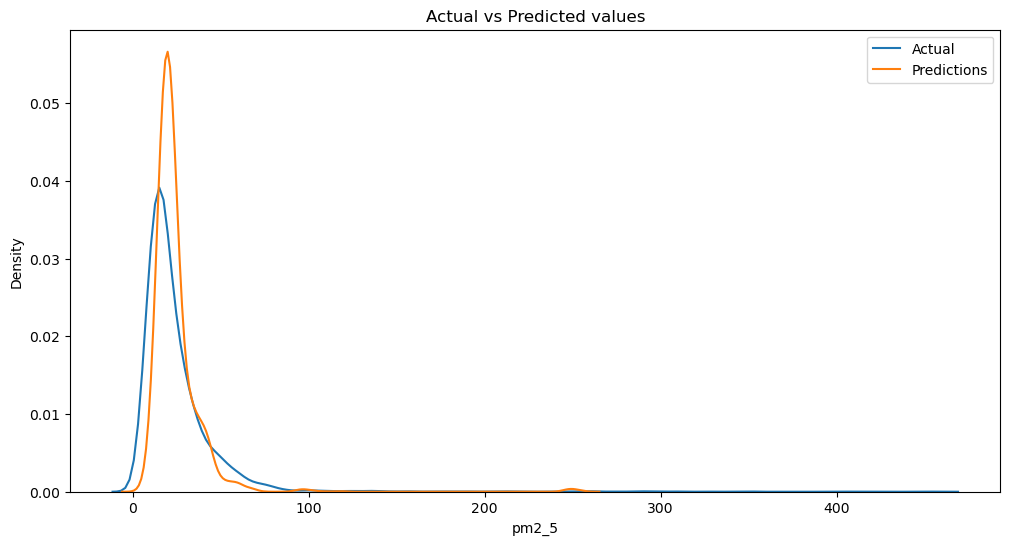

In [60]:
from sklearn.metrics import mean_absolute_error

# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')

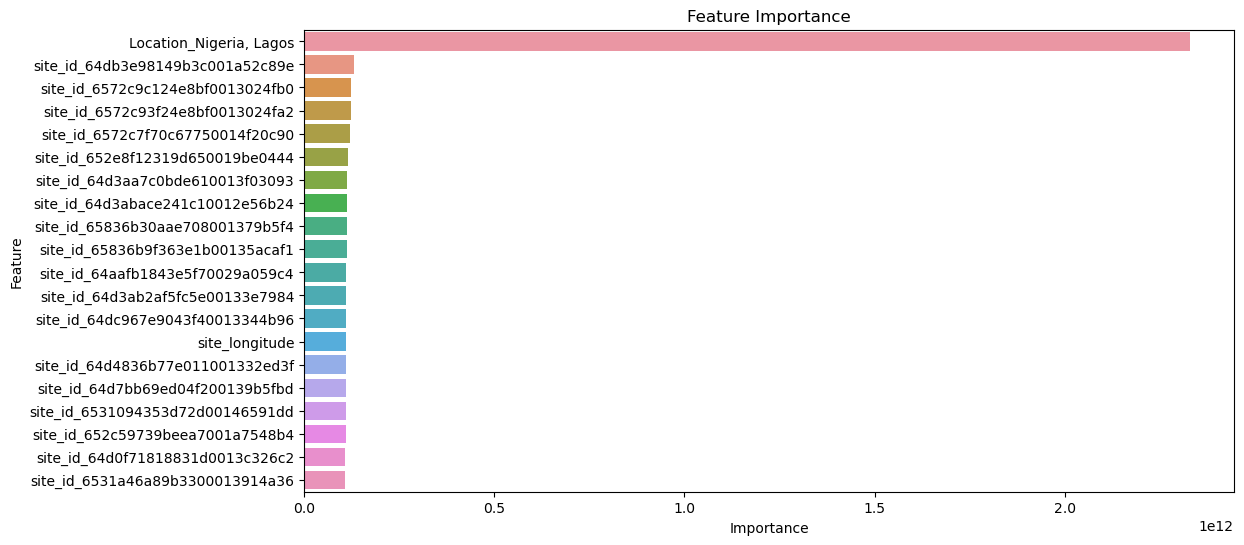

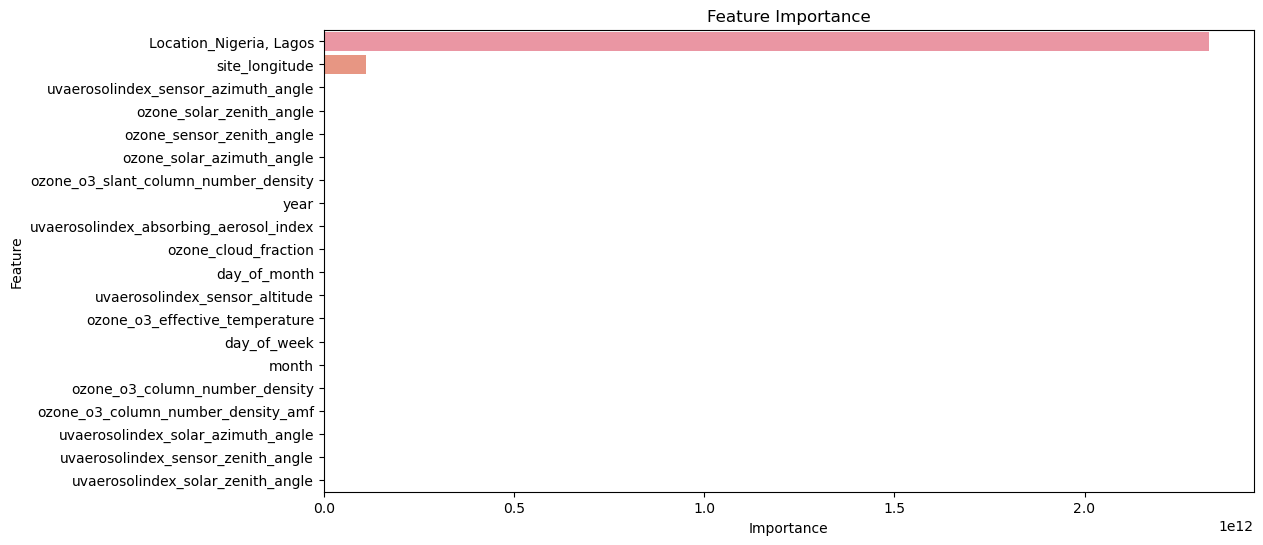

In [34]:
# Assume `model` is your trained LinearRegression model and `X_train` is your feature DataFrame
feature_importance = model.coef_

# Create a DataFrame to store the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame in order of feature importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Feature Importance')
plt.show()

# plot the feature importance of the 20 most important features where the feature does not include "site_id"
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[~feature_importance_df["Feature"].str.contains("site_id")].head(20))
plt.title('Feature Importance')
plt.show()

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross_val_score
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Assume `train` and `test` are your DataFrames
X_train = train.drop(columns=['pm2_5'])
y_train = train['pm2_5']

# Instantiate the model with adjusted parameters
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=rmse_scorer)  # cv=5 for 5-fold cross-validation

# cross_val_score negates the scores if greater_is_better=False, so negate the scores back
scores = -scores

print(f'Cross-validation RMSE: {scores}')
print(f'Average cross-validation RMSE: {scores.mean()}')

# Fit the model on the entire training data
rf.fit(X_train, y_train)

# Make predictions
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Assess the model
train_rmse = rmse(y_train, train_preds)
test_rmse = rmse(y_test, test_preds)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

Cross-validation RMSE: [18.71715578 12.81613937 14.50177434 15.30767927 16.3402954 ]
Average cross-validation RMSE: 15.536608831903333
Train RMSE: 12.798301811032783
Test RMSE: 16.035003488750206
Train MAE: 6.823494454500067
Test MAE: 7.777574206744421


In [64]:
train.columns = train.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
test.columns = test.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np
from lightgbm import LGBMRegressor

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross_val_score
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Assume `train` and `test` are your DataFrames
X_train = train.drop(columns=['pm2_5'])
y_train = train['pm2_5']

# Instantiate the model
model = LGBMRegressor()

# Perform K-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)  # cv=5 for 5-fold cross-validation

# cross_val_score negates the scores if greater_is_better=False, so negate the scores back
scores = -scores

print(f'Cross-validation RMSE: {scores}')
print(f'Average cross-validation RMSE: {scores.mean()}')

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Assess the model
train_rmse = rmse(y_train, train_preds)
test_rmse = rmse(y_test, test_preds)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4137
[LightGBM] [Info] Number of data points in the train set: 5099, number of used features: 80
[LightGBM] [Info] Start training from score 24.692575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4131
[LightGBM] [Info] Number of data points in the train set: 5099, number of used features: 77
[LightGBM] [Info] Start training from score 24.569118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4131
[LightGBM] [Info] Number of data points in the train set: 5099, number of used features: 78
[LightGBM] [Info] Start trai

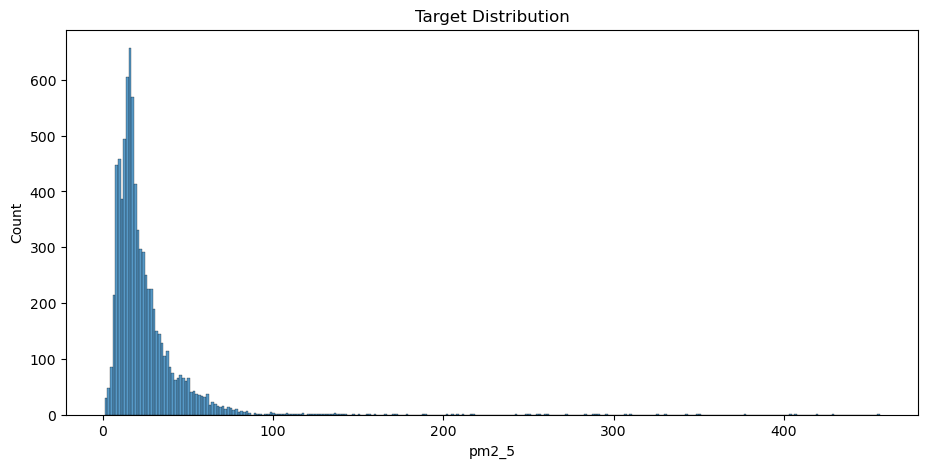

In [ ]:

# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

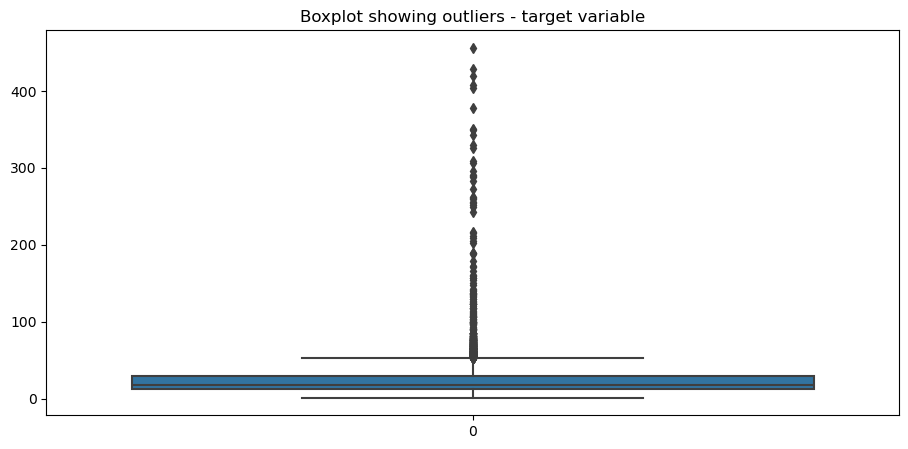

In [ ]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


In [ ]:
# print a summary of each variable
train.describe()

,site_latitude,site_longitude,month,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5,day_of_week,day_of_month,year
count,7959.000000,7959.000000,7959.00000,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7959.000000,7.959000e+03,7959.000000,7959.000000,7959.000000,7959.000000
mean,0.640621,30.211743,6.14047,2.053334e-17,-1.750083e-13,2.142609e-17,2.660406e-16,2.178319e-16,-3.749566e-16,-1.187363e-15,-2.562203e-16,9.927422e-16,6.542100e-15,2.343479e-16,-8.927538e-19,1.173971e-16,0.000000,1.606957e-16,24.678353,3.104661,14.966076,2023.097123
std,2.169024,9.453829,3.41682,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063,1.000063e+00,25.028233,1.887773,8.799838,0.296143
min,-3.459970,3.201510,1.00000,-2.992070e+00,-2.968331e+00,-1.091282e+00,-2.183442e+00,-1.850981e+00,-2.667132e+00,-3.188283e+00,-1.522185e+00,-1.896853e+00,-5.095018e+00,-1.412344e+00,-1.091282e+00,-2.183453e+00,-1.850989,-2.667149e+00,1.200000,0.000000,1.000000,2023.000000
25%,0.288630,32.568643,3.00000,-7.068632e-01,-6.910505e-01,-9.898563e-01,-7.628487e-01,-9.516413e-01,-6.702530e-01,-4.282208e-01,-8.879088e-01,-8.563106e-01,-6.114287e-01,-9.291562e-01,-9.898563e-01,-7.628483e-01,-0.951646,-6.702600e-01,13.225700,2.000000,7.000000,2023.000000
50%,0.332610,32.600480,6.00000,-2.286169e-02,9.779324e-02,-9.544157e-01,2.340956e-01,1.306666e-01,2.447668e-02,2.202633e-01,-2.096003e-01,-1.809909e-01,3.693942e-02,-1.422697e-01,-9.544157e-01,2.341041e-01,0.130666,2.447328e-02,18.353800,3.000000,15.000000,2023.000000
75%,0.374653,32.647109,9.00000,5.915922e-01,6.844900e-01,1.003157e+00,8.559707e-01,9.296853e-01,7.422517e-01,6.729319e-01,7.749230e-01,7.406296e-01,6.668014e-01,1.131633e+00,1.003160e+00,8.559844e-01,0.929688,7.422520e-01,28.882450,5.000000,23.000000,2023.000000
max,6.595400,36.914272,12.00000,3.550638e+00,3.903211e+00,1.047565e+00,1.334496e+00,1.607002e+00,2.481205e+00,2.548217e+00,2.413955e+00,2.528334e+00,3.804942e+00,1.322258e+00,1.047565e+00,1.324737e+00,1.607007,2.481214e+00,456.193333,6.000000,31.000000,2024.000000


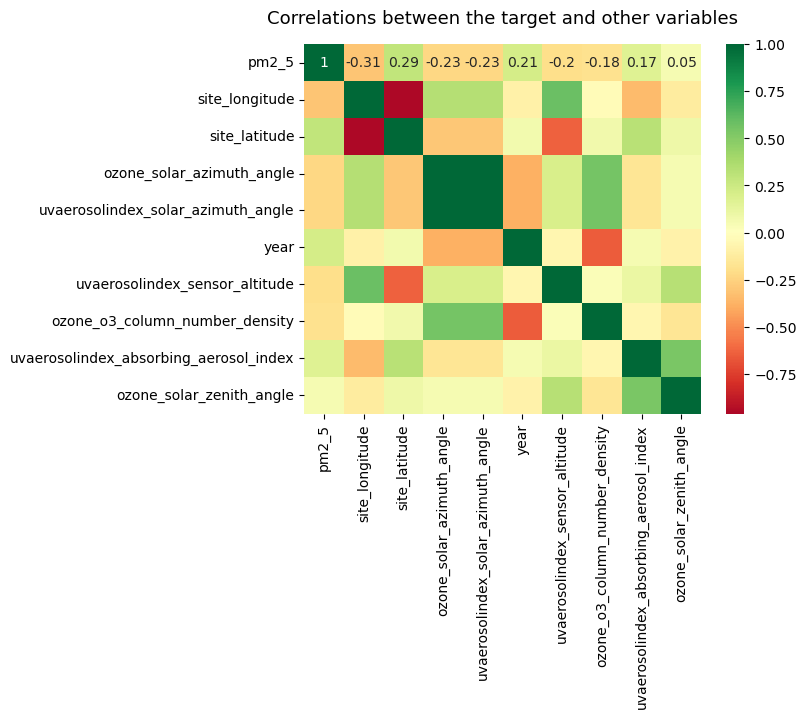

In [ ]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [ ]:
# Select X and y features for modelling
X = train_num_df.drop('pm2_5', axis = 1)
y = train.pm2_5

test_df = test[X.columns]
test_df.head()

KeyError: "['day_of_week', 'day_of_month', 'year'] not in index"

In [ ]:
train.head()

,id,site_id,site_latitude,site_longitude,date,hour,month,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5,Location
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,2023-10-25,13,10.0,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,12.015000,"Nigeria, Lagos"
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-02,12,11.0,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,42.267200,"Nigeria, Lagos"
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-03,13,11.0,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,39.450741,"Nigeria, Lagos"
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-08,14,11.0,0.591543,828920.6875,-95.863083,65.508858,-122.218231,43.923038,0.118412,3.505708,0.416643,226.529633,1.000000,-95.863083,65.508858,-122.218231,43.923038,10.537600,"Nigeria, Lagos"
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-09,13,11.0,0.069669,828919.0000,-97.811241,49.513344,-126.064468,40.167336,0.117899,2.796072,0.334256,226.368851,0.226150,-97.811241,49.513344,-126.064468,40.167336,19.431731,"Nigeria, Lagos"


In [ ]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LGBMRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

[LightGBM] [Fatal] Do not support special JSON characters in feature name.


LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
# Make predictions on the test set
preds = model.predict(test_df)

# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})

# Preview sub file
sub.head()

,id,pm2_5
0,id_ihxgrbq8bw,15.201729
1,id_dg6s4fhiwe,20.077817
2,id_f7hwwtmuzp,16.099079
3,id_ioese5awdg,20.621268
4,id_hdw320zpls,18.518781


In [ ]:
# Create a csv file
sub.to_csv('submission.csv', index = False)